In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
# interactivo, exportable:
%matplotlib notebook
# más rápido:
# %matplotlib inline

dataframes = (pd.read_csv("../data1/data.{}".format(day)) for day in ['18may','19may','20may','21may','22may','23may','24may'])
#dataframes = (pd.read_csv("../data/data.{}".format(day)) for day in ['22may']) # hay 24 sesiones con max_prio=3
grouped_data = pd.concat(dataframes)
grouped_data.head()

,src_ip,dst_ip,proto,src_port,dst_port,anom_level,threat_level,max_prio,count_events
0,172.24.82.30,85,1,429,2,0.02,0.0,4,908
1,10.181.49.25,79,1,6290,2,0.25,0.0,4,23523
2,125.71.1.6,52,1,1347,2,0.26,0.0,4,4124
3,180.106.6.172,148,2,414,4,0.10,0.0,4,1032
4,172.24.68.251,37,1,2120,2,0.25,0.0,4,6465


# K-Means

In [2]:
from sklearn.cluster import KMeans

x_varnames = [['dst_port','dst_ip'], ['count_events','dst_ip'], ['max_prio','dst_ip']]

x_vars = []
for n in x_varnames:
    x_vars.append(grouped_data[n].iloc[: , :].values)

## Selección de K por el método del codo

Por lo visto en la gráfica, se probarán:
- **k=2** y **k=3** para 'dst_port','dst_ip'
- **k=3** y **k=4** para 'count_events','dst_ip'

<IPython.core.display.Javascript object>


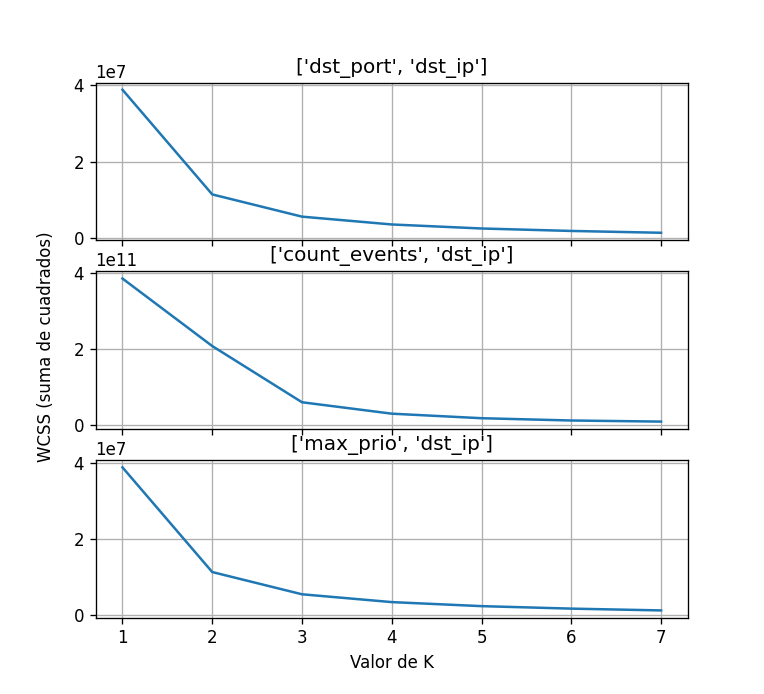

In [3]:
#%%time

fig, axis = plt.subplots(len(x_vars), sharex=True)

for i,x in enumerate(x_vars):
    WCSS = []
    for k in range(1,8):
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(x)
        WCSS.append(kmeans.inertia_)

    axis[i].title.set_text(x_varnames[i])
    axis[i].plot(range(1,8),WCSS)
    axis[i].grid()

#plt.ylabel("WCSS (suma de cuadrados)") # suma de las distancias al cuadrado
                                        # entre cada miembro del cluster y su centroide
fig.text(0.06, 0.5, "WCSS (suma de cuadrados)", ha='center', va='center', rotation='vertical')
plt.xlabel("Valor de K")

plt.show()

## =>> Parámetros a elegir <<=

In [4]:
# índice de los x_vars, para probar con una pareja cada vez:

#i = 0 # ['dst_port','dst_ip']
i = 1 # ['count_events','dst_ip']
#i = 2 # ['max_prio','dst_ip']

# valor de k con el que se está probando:

#k = 2
k = 3
#k = 4

## =========

(Código adaptado de [https://www.kaggle.com/burakkahveci/unsupervised-learning-applications](https://www.kaggle.com/burakkahveci/unsupervised-learning-applications))

In [5]:
#%%time

algo = KMeans(n_clusters = k) #,init='k-means++', n_init = 10 ,max_iter=300, 
#                        tol=0.0001,  random_state= 111  , algorithm='elkan')

clusters = algo.fit_predict(x_vars[i])
labels = algo.labels_
centroids = algo.cluster_centers_

In [6]:
#%%time

h = 5 # resolution in the meshgrid. higher h -> lower MemAllocated
x_min, x_max = x_vars[i][:, 0].min() - 1, x_vars[i][:, 0].max() + 1
y_min, y_max = x_vars[i][:, 1].min() - 1, x_vars[i][:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = algo.predict(np.c_[xx.ravel(), yy.ravel()])

<IPython.core.display.Javascript object>


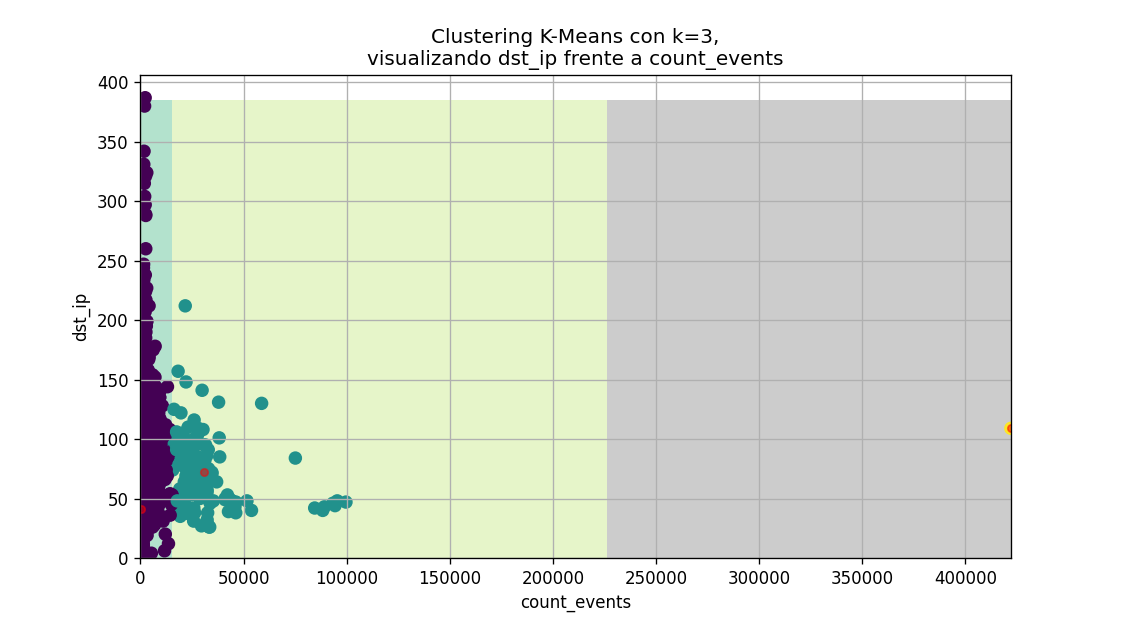

In [7]:
#%%time

Z = Z.reshape(xx.shape)
plt.imshow(Z , interpolation='nearest', 
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap = plt.cm.Pastel2, aspect = 'auto', origin='lower')

plt.scatter( x = x_varnames[i][0], y = x_varnames[i][1], data = grouped_data, c = labels, s = 50 )
plt.scatter(x = centroids[: , 0] , y =  centroids[: , 1] , s = 20 , c = 'red' , alpha = 0.5)
plt.ylabel(f'{x_varnames[i][1]}') , plt.xlabel(f'{x_varnames[i][0]}')
plt.grid()
plt.title(f"Clustering K-Means con k={k},\nvisualizando {x_varnames[i][1]} frente a {x_varnames[i][0]}")
plt.show()